# Regression Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

C:\Programs\WPy64-39100\python-3.9.10.amd64\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get the data

Text(0.5, 1.0, 'Sales in Several UK Regions')

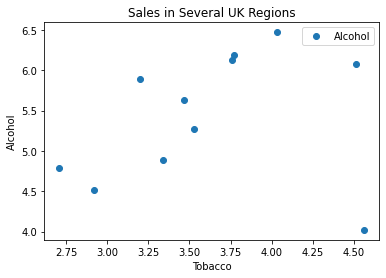

In [2]:
data_str = '''Region Alcohol Tobacco
North 6.47 4.03
Yorkshire 6.13 3.76
Northeast 6.19 3.77
East_Midlands 4.89 3.34
West_Midlands 5.63 3.47
East_Anglia 4.52 2.92
Southeast 5.89 3.20
Southwest 4.79 2.71
Wales 5.27 3.53
Scotland 6.08 4.51
Northern_Ireland 4.02 4.56'''

# Read in the data. Note that for Python 2.x, you have to change the "import" statement
from io import StringIO
df = pd.read_csv(StringIO(data_str), sep=r'\s+')

# Plot the data
df.plot('Tobacco', 'Alcohol', style='o')
plt.ylabel('Alcohol')
plt.title('Sales in Several UK Regions')
#plt.show()

## Show Regression Analysis

In [3]:
result = sm.ols('Alcohol ~ Tobacco', df[:-1]).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     12.78
Date:                Wed, 23 Nov 2022   Prob (F-statistic):            0.00723
Time:                        13:32:41   Log-Likelihood:                -4.9998
No. Observations:                  10   AIC:                             14.00
Df Residuals:                       8   BIC:                             14.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0412      1.001      2.038      0.0

C:\Programs\WPy64-39100\python-3.9.10.amd64\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Model Parameters

### F-Test

In [4]:
N = result.nobs
k = result.df_model+1
dfm, dfe = k-1, N - k
F = result.mse_model / result.mse_resid
p = 1.0 - stats.f.cdf(F,dfm,dfe)
print('F-statistic: {:.3f},  p-value: {:.5f}'.format( F, p ))

F-statistic: 12.785,  p-value: 0.00723


### Likelihood

In [5]:
N = result.nobs
SSR = result.ssr
s2 = SSR / N
L = ( 1.0/np.sqrt(2*np.pi*s2) ) ** N * np.exp( -SSR/(s2*2.0) )
print('ln(L) =', np.log( L ))

ln(L) = -4.999758697385981


## Coefficients

In [6]:
print(result.params)

Intercept    2.041223
Tobacco      1.005896
dtype: float64


### Standard Error

In [7]:
# Standard Errors
df['Eins'] = np.ones(( len(df), ))
Y = df.Alcohol[:-1]
X = df[['Tobacco','Eins']][:-1]

In [8]:
X = df.Tobacco[:-1]

# add a column of ones for the constant intercept term
X = np.vstack(( np.ones(X.size), X ))

# convert the NumPy arrray to matrix
X = np.matrix( X )

# perform the matrix multiplication,
# and then take the inverse
C = np.linalg.inv( X * X.T )

# multiply by the MSE of the residual
C *= result.mse_resid

# take the square root
SE = np.sqrt(C)

print(SE)

[[1.00136021        nan]
 [       nan 0.28132158]]


C:\Users\thomas\AppData\Local\Temp\ipykernel_11436\1407635291.py:17: RuntimeWarning: invalid value encountered in sqrt
  SE = np.sqrt(C)


### T-statistic

In [9]:
ii = 1
beta = result.params[ii]
se = SE[ii,ii]
t = beta / se
print('t =', t)

t = 3.575608454239029


In [10]:
N = result.nobs
k = result.df_model + 1
dof = N - k
p_onesided = 1.0 - stats.t( dof ).cdf( t )
p = p_onesided * 2.0
print('p = {0:.3f}'.format(p))

p = 0.007


### Confidence Intervals

In [11]:
ii = 0

# the estimated coefficient, and its variance
beta, c = result.params[ii], SE[ii,ii]

# critical value of the t-statistic
N = result.nobs
P = result.df_model
dof = N - P - 1
z = stats.t( dof ).ppf(0.975)

# the confidence interval
print(beta - z * c, beta + z * c)

-0.2679177093709968 4.350363883047413


## Analysis of Residuals

### Skew and Kurtosis

In [12]:
d = Y - result.fittedvalues
S = np.mean( d**3.0 ) / np.mean( d**2.0 )**(3.0/2.0)
K = np.mean( d**4.0 ) / np.mean( d**2.0 )**(4.0/2.0)
print('Skewness: {:.3f},  Kurtosis: {:.3f}'.format( S, K ))

Skewness: -0.014,  Kurtosis: 1.527


### Omnibus Test

In [13]:
def Z1( s, n ):
    Y = s * np.sqrt( ( ( n + 1 )*( n + 3 ) ) / ( 6.0 * ( n - 2.0 ) ) )
    b = 3.0 * ( n**2.0 + 27.0*n - 70 )*( n + 1.0 )*( n + 3.0 )
    b /= ( n - 2.0 )*( n + 5.0 )*( n + 7.0 )*( n + 9.0 )
    W2 = - 1.0 + np.sqrt( 2.0 * ( b - 1.0 ) )
    alpha = np.sqrt( 2.0 / ( W2 - 1.0 ) )
    z = 1.0 / np.sqrt( np.log( np.sqrt( W2 ) ) )
    z *= np.log( Y / alpha + np.sqrt( ( Y / alpha )**2.0 + 1.0 ) )
    return z

def Z2( k, n ):
    E = 3.0 * ( n - 1.0 ) / ( n + 1.0 )
    v = 24.0 * n * ( n - 2.0 )*( n - 3.0 )
    v /= ( n + 1.0 )**2.0*( n + 3.0 )*( n + 5.0 )
    X = ( k - E ) / np.sqrt( v )
    b = ( 6.0 * ( n**2.0 - 5.0*n + 2.0 ) ) / ( ( n + 7.0 )*( n + 9.0 ) )
    b *= np.sqrt( ( 6.0 * ( n + 3.0 )*( n + 5.0 ) ) / ( n * ( n - 2.0 )*( n - 3.0 ) ) )
    A = 6.0 + ( 8.0 / b )*( 2.0 / b + np.sqrt( 1.0 + 4.0 / b**2.0 ) )
    z = ( 1.0 - 2.0 / A ) / ( 1.0 + X * np.sqrt( 2.0 / ( A - 4.0 ) ) )
    z = ( 1.0 - 2.0 / ( 9.0 * A ) ) - z**(1.0/3.0)
    z /= np.sqrt( 2.0 / ( 9.0 * A ) )
    return z

K2 = Z1( S, N )**2.0 + Z2( K, N )**2.0
print('Omnibus: {}'.format( K2))

p = 1.0 - stats.chi2(2).cdf( K2 )
print('Pr( Omnibus ) = {}'.format( p ))

(K2, p) = stats.normaltest(result.resid)
print('Omnibus: {0}, p = {1}'.format(K2, p))

Omnibus: 2.541898169064931
Pr( Omnibus ) = 0.2805652152710678
Omnibus: 2.541898169064939, p = 0.2805652152710667


C:\Programs\WPy64-39100\python-3.9.10.amd64\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Durbin Watson

In [14]:
DW = np.sum( np.diff( result.resid.values )**2.0 ) / result.ssr
print('Durbin-Watson: {:.5f}'.format( DW ))

Durbin-Watson: 1.97535


### Jarque-Bera Test

In [15]:
JB = (N/6.0) * ( S**2.0 + (1.0/4.0)*( K - 3.0 )**2.0 )
p = 1.0 - stats.chi2(2).cdf(JB)
print('JB-statistic: {:.5f},  p-value: {:.5f}'.format( JB, p ))

JB-statistic: 0.90421,  p-value: 0.63629


### Condition Number

In [16]:
X = df.Tobacco[:-1]
 
# add a column of ones for the constant intercept term
X = np.vstack(( X, np.ones( X.size ) ))
 
# convert the NumPy arrray to matrix
X = np.matrix( X )
EV = np.linalg.eig( X * X.T )
print(EV)

(array([136.51527115,   0.18412885]), matrix([[ 0.96332746, -0.26832855],
        [ 0.26832855,  0.96332746]]))


In [17]:
CN = np.sqrt( EV[0].max() / EV[0].min() )
print('Condition No.: {:.5f}'.format( CN ))

Condition No.: 27.22887
